In [25]:
%matplotlib inline
from numpy import sin, linspace, pi
#from pylab import plot, show, title, xlabel, ylabel, subplot
from scipy import fft, arange
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
from peakutils.plot import plot as pplot

In [255]:
df = pd.read_csv('/home/kulkatr1/sabbatical/amplitude_analysis/151210004_RAW.txt', sep='\t',comment='#',skip_blank_lines=True)

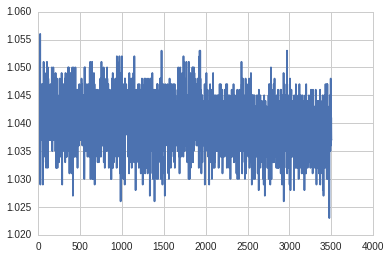

In [305]:
%matplotlib inline
plt.close()
#plt.plot(df.D7[3500:])
#plt.plot(df.D7[:3000:])
plt.plot(df.E11[3500:])

In [263]:
def filter_highfreq(fftdata,k,sampling_interval,freq):
    adjust_length=len(fftdata)
    fmax=1.0/(2.0*sampling_interval)
    fmin=1.0/(adjust_length*sampling_interval)
    fc=k*fmax
    deltaf=fmin
    pos_index=math.ceil(fc/deltaf)
    #print pos_index, freq[pos_index] , fc
    neg_index= (adjust_length-pos_index)
    #print neg_index, freq[neg_index], fc
    fft_new_data=np.array(fftdata, copy=True)
    fft_new_data.imag[pos_index:neg_index+1]=0.0
    fft_new_data.real[pos_index:neg_index+1]=0.0
    #print fft_new_data1[pos_index].real
    #print fft_new_data1[pos_index].imag
    #inverse fft 
    filtered_data=np.fft.ifft(fft_new_data)
    return filtered_data

In [44]:
def calculate_fft(data, data_length, sampling_interval):
    Ts = float(sampling_interval)                      # sampling interval
    Fs =float(1.0/Ts)                      # sampling rate
    t = np.arange(0,data_length-1)  * Ts          # time vector
    #fft_data=np.fft.fft(data1)/float(data_length)
    #print "data len", data_length
    fft_data=np.fft.fft(data)
    #plt.figure()
    #plt.plot(abs(fft_data))
    #freq=arange(0,(data_length/2)) * (1.0/(data_length*sampling_interval))
    freq = np.fft.fftfreq(data_length, d=Ts)
    Y= (2.0/data_length)* np.abs(fft_data[0:data_length/2])
    return freq,Y, fft_data

def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

positive freq: 0-2047 ( 0 :  ((n/2)-1)), written from lower to higher freq

negative freq : 2048-n ( (n/2) : (n-1)), written from higher to lower freq

(n/2)th value has a frequency of -(1/2dt)

In [325]:
import math 
import peakutils as pk
def calculate_baseline(pre_compound_point,post_compound_point,column_name):
    k=0.01 #parameter to filter high frequency  signal,(instrument noise)
    first_data=(df[column_name].values[:pre_compound_point])
    second_data= (df[column_name].values[post_compound_point:])
    first_data_len = len(first_data)
    second_data_len = len(second_data)
    len1= max(first_data_len,second_data_len)
    #adjust the length interms of power of 2
    p = math.log(len1,2)
    adjust_length= 2 ** math.ceil(p)
    sampling_interval = (56.0/1000.0)
    mean1=first_data.mean()
    print mean1, 'mean for first'
    data1= first_data-mean1
    data_adjust1 =np.asarray(list(data1) + [0.0] * int(adjust_length - len(data1)))
    #get fft
    freq1, y1, fft_data1 = calculate_fft(data_adjust1,len(data_adjust1), sampling_interval)
    #filter high frequency data
    filtered_data1=filter_highfreq(fft_data1,k,sampling_interval,freq1)
    filtered_data1_nopad = filtered_data1[:first_data_len] + mean1
    base1=pk.baseline(filtered_data1_nopad, deg=4)
    #base1_avg = base1.mean()
    #take mean of rolling average base points
    base1_avg = movingaverage(base1, 5).mean().real
    #plot
    #plt.figure()
    #%matplotlib notebook
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8), 
                        tight_layout=True)
    ax1,ax2= axes.ravel()
  
    #ax1.figure()
    ax1.plot(base1,label='base amplitudes')
    ax1.plot(filtered_data1_nopad)
    ax1.axhline(y=base1_avg, xmin=0, xmax=0.9, linewidth=2, color = 'r',label='before avg_baseline'+str(base1_avg.real))
    ax1.legend()
    ########################repeat for second 
    mean2=second_data.mean()
    data2= second_data- mean2
    data_adjust2=np.asarray(list(data2) + [0.0] * int(adjust_length - len(data2)))
    print mean2, 'mean for second'
    #print "original length", data_adjust
    freq2, y2, fft_data2 = calculate_fft(data_adjust2, len(data_adjust2), (56.0/1000.0))
    filtered_data2=filter_highfreq(fft_data2,k,sampling_interval,freq2)
    filtered_data2_nopad = filtered_data2[:second_data_len] + mean2
    base2=pk.baseline(filtered_data2_nopad, deg=4)
    #base2_avg = base2.mean()
    base2_avg = movingaverage(base2, 5).mean().real

    ax2.plot(base2,label='base amplitudes')
    ax2.plot(filtered_data2_nopad)
    ax2.axhline(y=base2_avg, xmin=0, xmax=0.9, linewidth=2, color = 'r', label='after avg_baseline' +str(base2_avg.real))
    ax2.legend()
    return  filtered_data1_nopad, filtered_data2_nopad, base1_avg,base2_avg

    

1.00934933333 mean for first
1.03988420724 mean for second


/usr/prog/python/2.7.9-goolf-1.5.14-NX/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/prog/python/2.7.9-goolf-1.5.14-NX/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


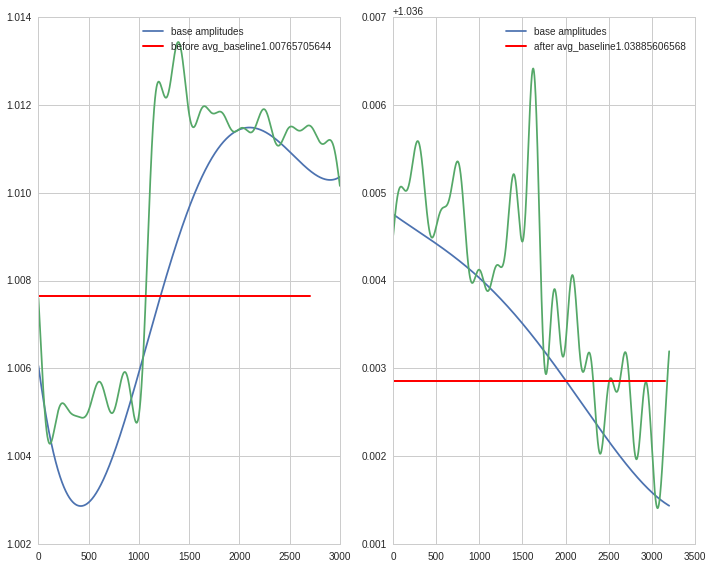

In [326]:
pre_compound_point = 3000
post_compound_point = 3800
plt.close('all')  
#column_names=["D7","D8", "F7","F8","D9", "B11", "C4","D12"]
column_names=["E11"]

for column_name in column_names:
        filtered_data1_nopad, filtered_data2_nopad, base1_avg, base2_avg = calculate_baseline(pre_compound_point,post_compound_point,column_name)


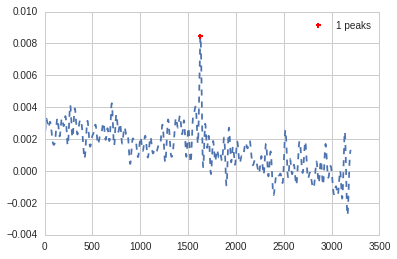

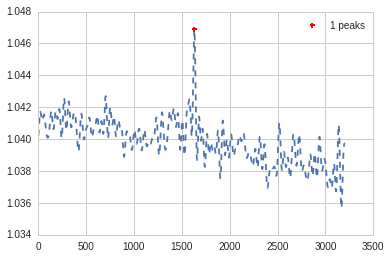

In [316]:
peak_index=pk.peak.indexes(filtered_data2_nopad-base2_avg, thres=0.7, min_dist=1)
plt.figure()
pplot(arange(0,len(filtered_data2_nopad)),filtered_data2_nopad-base2_avg, peak_index)
plt.figure()
pplot(arange(0,len(filtered_data2_nopad)),filtered_data2_nopad, peak_index)

In [63]:
2

array([   0,    1,    2, ..., 3201, 3202, 3203])

In [252]:
def plot_columns(ax1,colname, df):
    sns.set_style("whitegrid")
    ax1.plot(df[colname])
    ax1.set_title(colname)
filter_cols = []

newdf= pd.read_csv('/home/kulkatr1/sabbatical/amplitude_analysis/160902002_RAW_Ratio1.txt', sep=',',comment='#',skip_blank_lines=True)

24


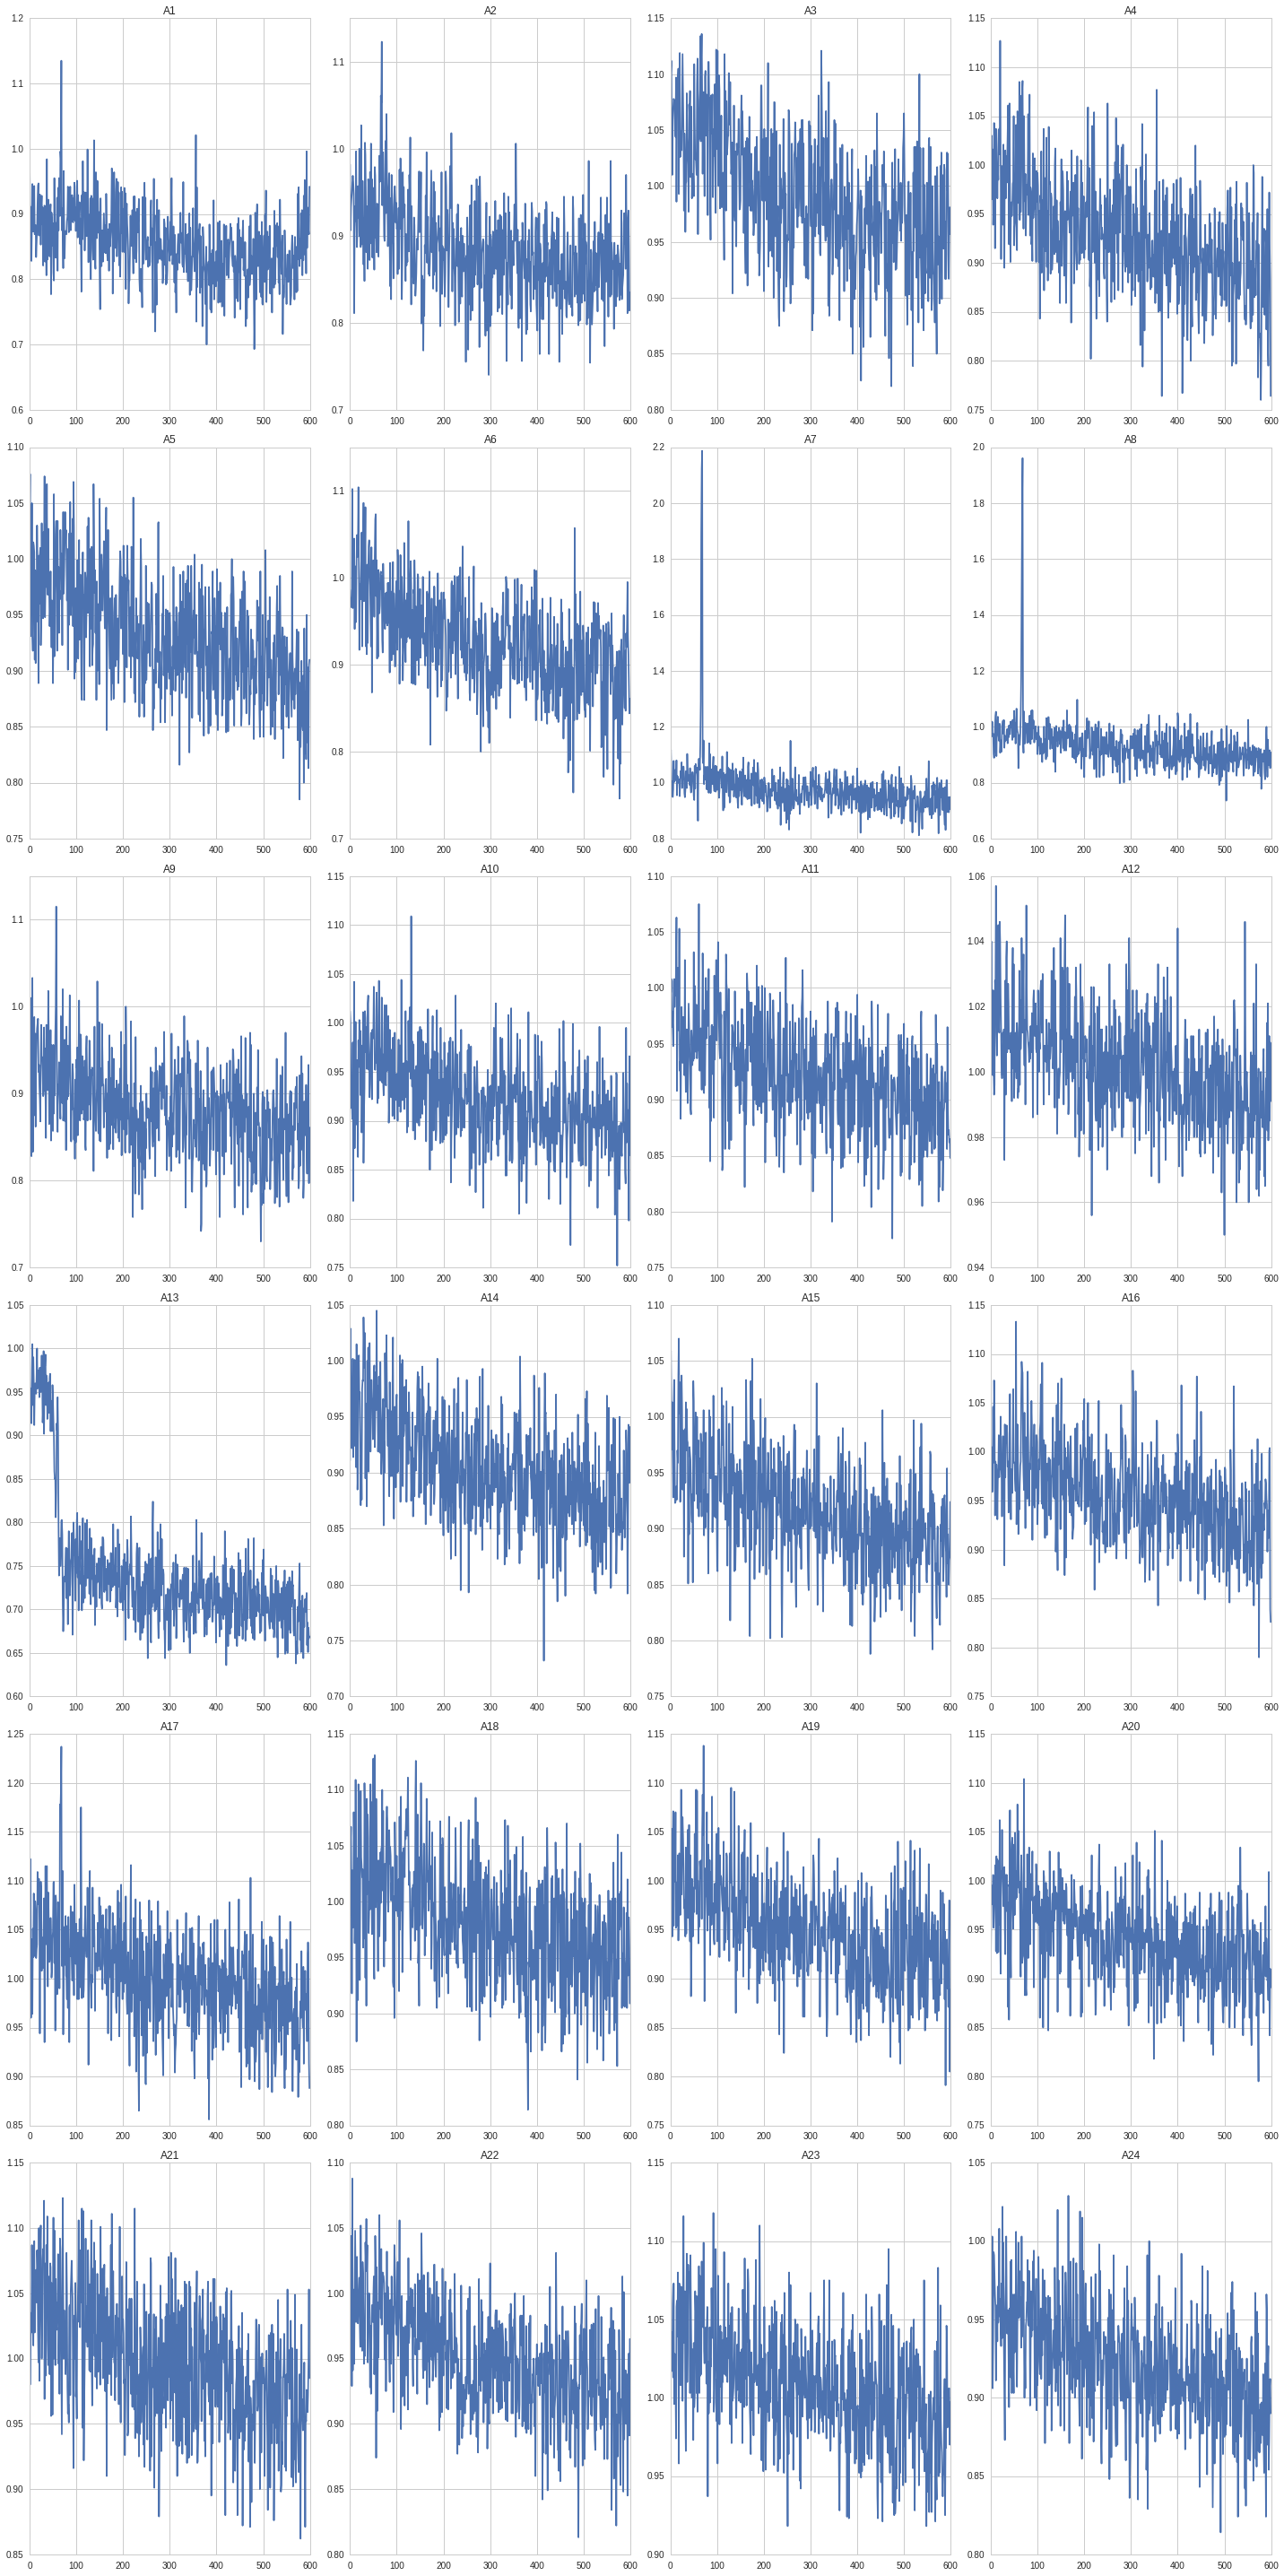

In [253]:
import re
filter_cols=[]
for i in newdf.columns.values:
    if re.search('\.',i):
        pass
    else:
        filter_cols.append(i)
filter_cols=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20',
       'A21', 'A22', 'A23', 'A24']
print len(filter_cols)
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 40), 
                        tight_layout=True)
for ax1,colname in zip(axes.ravel(),filter_cols):
    plot_columns(ax1,colname,newdf)

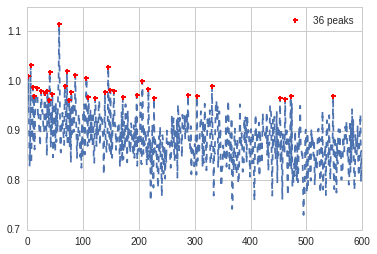

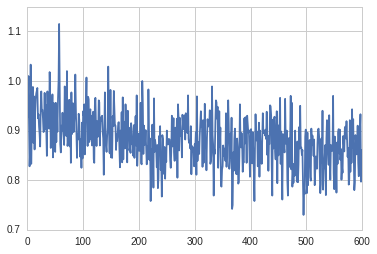

In [318]:
a3_base = pk.baseline(newdf['A9'])
peak_index=pk.peak.indexes(newdf['A9'], thres=0.6, min_dist=1)
plt.figure()
pplot(arange(0,len(newdf['A9'])),newdf['A9'], peak_index)
plt.figure()
plt.plot(newdf.A9)
plt.figure()
plt.plot(newdf.A9)

In [210]:
newdf

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24
1,0.983,0.982,1.094,0.985,1.04,0.986,1.066,1.033,0.926,1.012,...,0.953,0.991,1.064,0.98,0.988,0.958,1.031,0.931,1.041,1.302
2,0.902,0.906,1.102,1.025,1.076,0.967,1.118,1.006,0.953,1,...,0.912,1.044,1.023,0.917,0.991,1.031,0.998,0.977,1.063,1.164
3,0.887,0.933,1.112,1.03,0.931,0.967,1.043,0.988,1.01,0.913,...,0.887,1.013,1.161,0.873,0.922,0.925,0.984,0.88,0.978,1.114
4,0.911,0.942,1.038,0.965,0.985,0.966,0.957,1.018,0.916,0.924,...,0.865,0.929,1.026,0.893,0.967,0.914,0.972,0.875,0.995,1.129
5,0.828,0.948,1.01,1.016,0.971,0.979,1.005,0.965,0.828,0.922,...,0.855,0.906,1.077,0.943,0.914,0.918,0.899,0.974,0.988,0.914
6,0.882,0.961,1.052,0.939,1.05,1.102,0.949,0.976,0.86,0.902,...,0.884,1.011,1.099,0.957,0.798,0.984,0.935,0.981,1.003,0.951
7,0.946,0.969,1.07,0.959,0.932,0.965,0.975,0.902,1.033,0.98,...,0.909,1.042,1.054,0.93,1.007,0.946,0.941,0.872,0.957,1.07
8,0.918,0.962,1.078,1.043,0.918,1.003,1.078,0.889,0.833,0.818,...,0.984,0.967,1.096,0.93,0.997,0.964,0.973,0.954,0.861,1.04
9,0.873,0.948,1.077,1.005,1.015,1.042,1.002,0.912,0.905,0.967,...,0.984,1,1.133,0.909,0.956,1.033,0.948,0.982,1.013,1.169
10,0.884,0.811,1.073,0.915,1.012,1.045,1.008,1.003,0.893,1.042,...,0.929,0.965,1.1,0.892,0.948,1.011,0.984,0.902,0.938,1.048
